In [1]:
!pip -q install transformers accelerate datasets

In [2]:
import json
import pandas as pd

FILE_10K = "/content/reviews_10000.jsonl"

rows = []
with open(FILE_10K, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        rows.append({
            "review_id": obj.get("review_id"),
            "stars": obj.get("stars"),
            "text": obj.get("text")
        })

df = pd.DataFrame(rows).dropna(subset=["text", "stars"]).reset_index(drop=True)
print("Shape:", df.shape)
df.head(3)

Shape: (10000, 3)


,review_id,stars,text
0,J5Q1gH4ACCj6CtQG7Yom7g,2,Went for lunch and found that my burger was me...
1,HlXP79ecTquSVXmjM10QxQ,5,I needed a new tires for my wife's car. They h...
2,JBBULrjyGx6vHto2osk_CQ,5,Jim Woltman who works at Goleta Honda is 5 sta...


In [3]:
from transformers import pipeline

sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

print("Modèle DistilBERT chargé")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Modèle DistilBERT chargé


In [4]:
from transformers import DistilBertTokenizer
from datasets import Dataset

# Transformation des notes en labels 0-4
df["label"] = df["stars"] - 1

# Création du dataset HuggingFace
dataset = Dataset.from_pandas(df[["text", "label"]])

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

dataset = dataset.map(tokenize, batched=True)

# Nettoyage
dataset = dataset.remove_columns(["text"])
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
df_small = df.sample(2000, random_state=42)

In [6]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=5
)

training_args = TrainingArguments(
    output_dir="./distilbert_finetuned",
    eval_strategy="no",
    per_device_train_batch_size=4,  # plus petit = moins de mémoire
    num_train_epochs=1,             # 1 seule époque
    gradient_accumulation_steps=2   # compense le petit batch
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

trainer.train()

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Step,Training Loss
500,1.895853
1000,1.551103


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=1250, training_loss=1.6711587646484376, metrics={'train_runtime': 35191.7991, 'train_samples_per_second': 0.284, 'train_steps_per_second': 0.036, 'total_flos': 1324744857600000.0, 'train_loss': 1.6711587646484376, 'epoch': 1.0})

In [22]:
def predict_sentiment(text):

    result = sentiment_model(text)[0]
    label = result["label"].lower()

    if "very negative" in label:
        return "very negative"

    if "negative" in label:
        return "negative"

    if "neutral" in label:
        return "neutral"

    if "very positive" in label:
        return "very positive"

    if "positive" in label:
        return "positive"

    return "unknown"

In [25]:
test_texts = [

    "The food was disgusting and I got sick after eating here.",
    "Terrible experience, rude staff and cold food.",

    "The service was slow and the food was not very good.",
    "I didn't enjoy the meal, it was below average.",

    "It was okay, nothing special.",
    "The restaurant was average, not bad but not great.",

    "The food was good and the staff were friendly.",
    "Nice atmosphere and tasty dishes.",

    "Absolutely amazing experience, everything was perfect!",
    "Best restaurant ever, incredible food and service!"
]

for text in test_texts:
    print("=" * 60)
    print("Texte :", text)
    print("Prédiction :", predict_sentiment(text))

Texte : The food was disgusting and I got sick after eating here.
Prédiction : negative
Texte : Terrible experience, rude staff and cold food.
Prédiction : negative
Texte : The service was slow and the food was not very good.
Prédiction : negative
Texte : I didn't enjoy the meal, it was below average.
Prédiction : negative
Texte : It was okay, nothing special.
Prédiction : negative
Texte : The restaurant was average, not bad but not great.
Prédiction : negative
Texte : The food was good and the staff were friendly.
Prédiction : positive
Texte : Nice atmosphere and tasty dishes.
Prédiction : positive
Texte : Absolutely amazing experience, everything was perfect!
Prédiction : positive
Texte : Best restaurant ever, incredible food and service!
Prédiction : positive


In [15]:
def sentiment_to_rating(sentiment):

    if sentiment == "very negative":
        return 1

    if sentiment == "negative":
        return 2

    if sentiment == "neutral":
        return 3

    if sentiment == "positive":
        return 4

    if sentiment == "very positive":
        return 5

    return None

In [26]:
test_texts = [

    "The food was disgusting and I felt sick after.",
    "Terrible experience, I will never come back.",

    "The service was slow and the food was not very good.",
    "I didn't enjoy the meal, it was disappointing.",

    "It was okay, nothing special.",
    "The restaurant was average, not bad but not great.",

    "The food was good and I enjoyed it.",
    "Nice place and friendly staff.",

    "Absolutely amazing experience, everything was perfect!",
    "Best restaurant ever, incredible food and service!"
]

for text in test_texts:
    sentiment = predict_sentiment(text)
    rating = sentiment_to_rating(sentiment)

    print("=" * 60)
    print("Texte :", text)
    print("Polarité :", sentiment)
    print("Note estimée :", rating)

Texte : The food was disgusting and I felt sick after.
Polarité : negative
Note estimée : 1
Texte : Terrible experience, I will never come back.
Polarité : negative
Note estimée : 1
Texte : The service was slow and the food was not very good.
Polarité : negative
Note estimée : 1
Texte : I didn't enjoy the meal, it was disappointing.
Polarité : negative
Note estimée : 1
Texte : It was okay, nothing special.
Polarité : negative
Note estimée : 1
Texte : The restaurant was average, not bad but not great.
Polarité : negative
Note estimée : 1
Texte : The food was good and I enjoyed it.
Polarité : positive
Note estimée : 5
Texte : Nice place and friendly staff.
Polarité : positive
Note estimée : 5
Texte : Absolutely amazing experience, everything was perfect!
Polarité : positive
Note estimée : 5
Texte : Best restaurant ever, incredible food and service!
Polarité : positive
Note estimée : 5


In [37]:
import pandas as pd
from tqdm import tqdm

pd.set_option("display.max_colwidth", None)

# Prendre 50 avis aléatoires
sample_50 = df.sample(5000, random_state=42).reset_index(drop=True)

results = []

for _, row in tqdm(sample_50.iterrows(), total=5000):

    text = str(row["text"])
    true_stars = row["stars"]

    #Prédiction polarité
    result = sentiment_model(text, truncation=True)[0]
    label = result["label"].lower()

    if "very negative" in label:
        sentiment = "very negative"
    elif "negative" in label:
        sentiment = "negative"
    elif "neutral" in label:
        sentiment = "neutral"
    elif "very positive" in label:
        sentiment = "very positive"
    elif "positive" in label:
        sentiment = "positive"
    else:
        sentiment = "unknown"

    #Conversion polarité → note
    predicted_rating = sentiment_to_rating(sentiment)

    results.append({
        "true_stars": true_stars,
        "predicted_polarity": sentiment,
        "predicted_stars": predicted_rating,
        "text": text
    })

results_df = pd.DataFrame(results)

#Afficher les 50 lignes
results_df

100%|██████████| 5000/5000 [22:21<00:00,  3.73it/s]


,true_stars,predicted_polarity,predicted_stars,text
0,5,positive,5,Skip the starbucks. This is real stuff like that is high end. Go explore your taste buds.
1,2,negative,1,I placed an order that was confirmed for delivery only for it to never arrive. I called them 3-4 times before someone finally answered and it took them a week to give me a refund for the flowers my friend never received. Really disappointing.
2,5,positive,5,"They have cleaned our house 3 consecutive times over 6 weeks. The most recent visit was the best. I was late to work bc the babysitter didn't show up (our kids ages are 2, 4, 6). I left breakfast dishes on the counter, pajamas lying on the floor, etc as I ran out of the house. \n\nWhen I returned that evening, they had taken care of all the messes I had made in the rush. For a morning to be so crazy, it was an awesome evening with a perfectly clean house."
3,4,positive,5,Tiny place but delicious food. If you're willing to wait for something really tasty and comfortable in an informal environment I'd definitely suggest going here. We met up for an early lunch and spent awhile chatting and catching up while we ate and it was great.
4,5,positive,5,This place is amazing!!!!! Decor is super cool! Bartenders are great. The baguettes are to die for! As soon as we arrived we were given a quick tour (which was appreciated). The vibe overall was just So fun! We can't go back for another girls night.
...,...,...,...,...
4995,1,negative,1,"I ordered a roast beef hoagie, meat had no flavor. Also, i saw two cockroaches coming out of a hole on the floor. Definitely now going there again."
4996,1,positive,5,"I have gotten sick twice from eating at this place. The second time I just wanted to make sure this place wasn't as bad as I had concluded it to be. But a very disappointing experience, every single time. I can't believe in New Orleans, this is the quality of Ethiopian food people have to experience. Please, if you eat here, forgive the owners and don't judge Ethiopian food by this experience. Go to LA, NY, DC, ATL, and experience good Ethiopian food."
4997,5,positive,5,"Ten stars if I could because I absolutely love IV Drip. My go-to place for breakfast, lunch, sweets, and just about any type of pick-me-up you can imagine. I haven't had the chance to try everything on their menu just yet, so I'm going to share some of my favorites. \n\nTheir ice cream shakes are a bit on the pricey side, but oh so good. Their cookie-wiches are also really good; I usually get the cookies on the side so that I can savor them separately. My favorite breakfast option is the Morning Glory; it's always made to order so you know its fresh. My favorite lunch option is the Turkey Pesto panini, it's to die for! My absolute favorite cookie here is the s'mores cookie; I like to think of it as one of God's gifts to Earth, especially when they're fresh out the oven (crying emoji). They carry McConnell's ice cream and everything else is made in-house, which is such a plus. You can really taste the ""homemade-ness"" in everything. Finally, their staff is super friendly, welcoming, and funny. \n\nIf you go to UCSB or are visiting IV and haven't made a visit here, you should definitely give it a chance. You won't be disappointed :)"
4998,1,negative,1,"We waited in line for almost 20 minutes just to get in to the store. They took my name and stated someone would be around to help me within 15 minutes. All I wanted was to purchase a gift card. There were 2 sales associates behind the counter laughing and talking to each other. I walked up and asked if I could purchase the gift certificate and was quickly and very rudely told when my name was called someone else would help me, then they walked away. So I sat and waited another 20 minutes just to walk back up the same counter for a 2 minute transaction. Completely unprofessional and a deterrent from purchasing anything else for the store. It's a shame because the products are beautiful."


========== PERFORMANCE RATING (1-5) : 0.603 ==========

              precision    recall  f1-score   support

           1      0.480     0.978     0.644       780
           2      0.000     0.000     0.000       385
           3      0.000     0.000     0.000       503
           4      0.000     0.000     0.000       975
           5      0.661     0.956     0.782      2357

    accuracy                          0.603      5000
   macro avg      0.228     0.387     0.285      5000
weighted avg      0.386     0.603     0.469      5000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


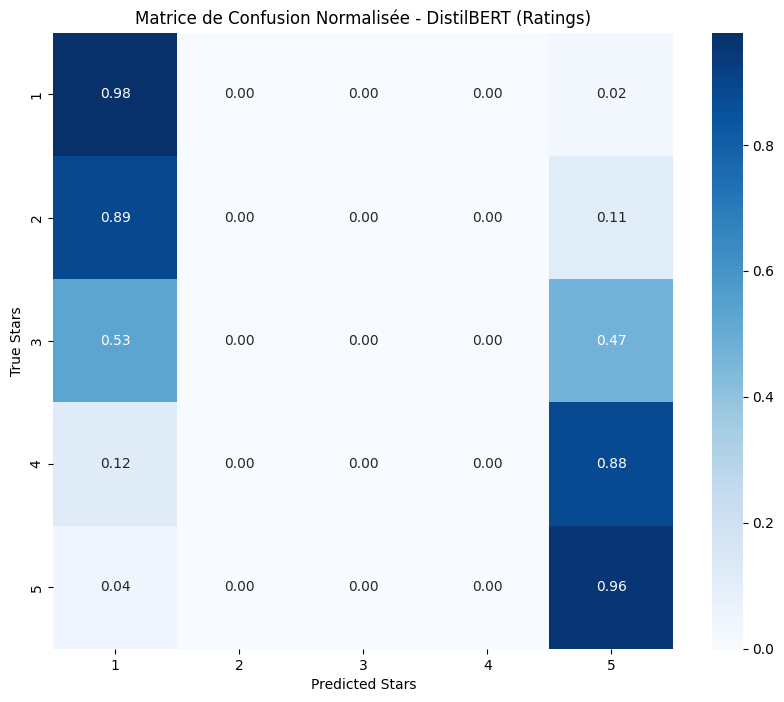

In [39]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_true_stars = results_df["true_stars"]
y_pred_stars = results_df["predicted_stars"]

acc_stars = accuracy_score(y_true_stars, y_pred_stars)
# Normalisation par ligne pour avoir les pourcentages (0.00 à 1.00)
cm_stars = confusion_matrix(y_true_stars, y_pred_stars, normalize='true')

#AFFICHAGE TEXTE
print(f"========== PERFORMANCE RATING (1-5) : {acc_stars:.3f} ==========\n")
print(classification_report(y_true_stars, y_pred_stars, digits=3))

#  VISUALISATION
plt.figure(figsize=(10, 8))

labels_stars = np.unique(y_true_stars)

sns.heatmap(
    cm_stars,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels_stars,
    yticklabels=labels_stars
)

plt.title("Matrice de Confusion Normalisée - DistilBERT (Ratings)")
plt.xlabel("Predicted Stars")
plt.ylabel("True Stars")
plt.show()

========== PERFORMANCE POLARITÉ : 0.897 ==========

              precision    recall  f1-score   support

    negative      0.863     0.822     0.842      1668
    positive      0.913     0.935     0.924      3332

    accuracy                          0.897      5000
   macro avg      0.888     0.878     0.883      5000
weighted avg      0.896     0.897     0.896      5000



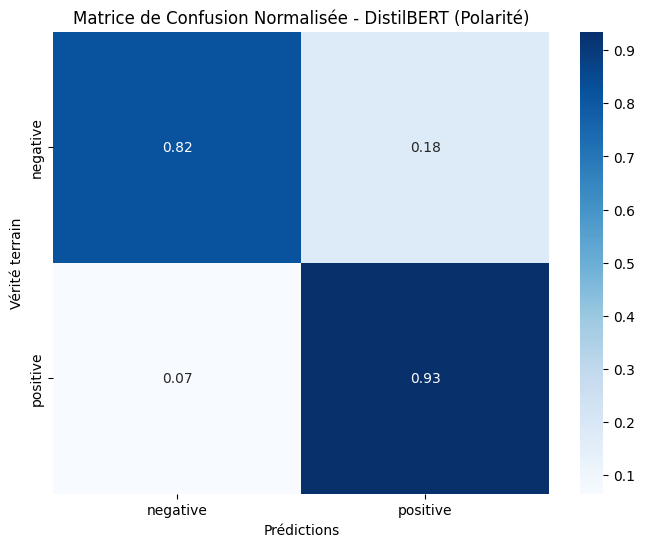

In [40]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

if "true_polarity" not in results_df.columns:
    results_df["true_polarity"] = results_df["true_stars"].apply(lambda x: "positive" if x > 3 else "negative")

y_true_pol = results_df["true_polarity"]
y_pred_pol = results_df["predicted_polarity"]

acc_pol = accuracy_score(y_true_pol, y_pred_pol)
# Normalisation pour avoir les pourcentages (0.00 à 1.00)
cm_pol = confusion_matrix(y_true_pol, y_pred_pol, normalize='true')

print(f"========== PERFORMANCE POLARITÉ : {acc_pol:.3f} ==========\n")
print(classification_report(y_true_pol, y_pred_pol, digits=3))

plt.figure(figsize=(8, 6))

# On récupère les labels uniques (normalement ['negative', 'positive'])
labels_pol = np.unique(y_true_pol)

sns.heatmap(
    cm_pol,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels_pol,
    yticklabels=labels_pol
)

plt.title("Matrice de Confusion Normalisée - DistilBERT (Polarité)")
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.show()